<a href="https://colab.research.google.com/github/chengning-zhang/Intern-SWIB/blob/master/Week3_still_signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data

In [ ]:
!pip install shap

In [126]:
import pandas as pd
from patsy import dmatrix
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from joblib import Parallel, delayed
import multiprocessing
import shap
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn import svm
import xgboost as xgb
from sklearn.metrics import r2_score

### Read LIBOR rate

convert LIBOR rate to return, which is then treated as risk free return. 
For more accurate beta calculation: (r_i - rf) = beta (r_m - rf )


Text(0, 0.5, 'Libor rate')

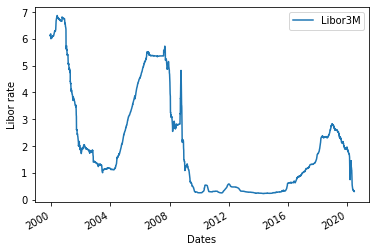

In [ ]:
libor_rate = pd.read_excel('/content/drive/My Drive/SWIB Quant Intern/data folder/libor.xlsx')  
# plot rate
libor_rate.plot(x = 'Dates', y = 'Libor3M')
# libor_rate.isna().sum(), libro_rate does not have nan, no need fillna('ffill')
plt.ylabel('Libor rate')

The fomula from rate to return: 

$return_t + 1 = \frac{P_t}{P_{t-1}} $

$ P_{t-1} (1 + \frac{rate_{t-1}}{100})^{days/year} = P_t$

Therefore, $return_t =  (1 + \frac{rate_{t-1}}{100})^{days/year} - 1 $

Text(0.5, 1.0, 'Daily return for Libor')

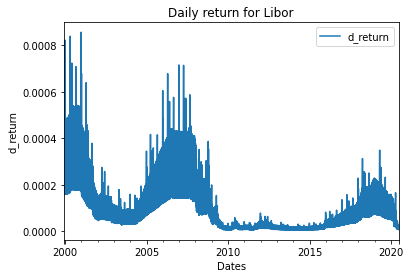

In [ ]:
libor_rate['years'] = libor_rate['Dates'].diff().dt.total_seconds()/(365*24*3600)
libor_rate['d_return']=np.power(1+libor_rate['Libor3M'].shift(periods=1)/100,libor_rate['years'])-1   
libor_rate = libor_rate.drop(['Libor3M','years'], axis=1)
# after obtain d_return, make year_month and date to period
libor_rate['year_month'] = libor_rate['Dates'].dt.to_period('M')
libor_rate['Dates'] = libor_rate['Dates'].dt.to_period('D')
# plot d_return
libor_rate.plot(x = 'Dates', y = 'd_return')
plt.ylabel('d_return')
plt.title('Daily return for Libor')

In [ ]:
# 2000-04-21. - 2000-04-24 are missing,  but two of them are present in spxt, which is why there will be nan when left_join
libor_rate.loc[libor_rate['Dates'] >= '2000-04-20']

,Dates,d_return,year_month
97,2000-04-20,0.000168,2000-04
98,2000-04-25,0.000840,2000-04
99,2000-04-26,0.000168,2000-04
100,2000-04-27,0.000169,2000-04
101,2000-04-28,0.000170,2000-04
...,...,...,...
5187,2020-06-15,0.000026,2020-06
5188,2020-06-16,0.000008,2020-06
5189,2020-06-17,0.000008,2020-06
5190,2020-06-18,0.000009,2020-06


Make monthly return for Libor, 
Note this m_return is (price_t.iloc[-1] - price_t-1.iloc[-1])/ ... ,  
not exactly same as (price_t.iloc[-1] - price_t.iloc[0])/ ... where I calculate stock return and market return


In [ ]:
# initial monthly libor return
libor_rate_m = pd.DataFrame({'year_month': libor_rate['year_month'].unique()})
# note this m_return is (price_t.iloc[-1] - price_t-1.iloc[-1])/ ... ,  not exactly same as (price_t.iloc[-1] - price_t.iloc[0])/ ...
libor_rate_m['m_return'] = libor_rate.groupby('year_month').apply(lambda df: (df.d_return + 1).cumprod().iloc[-1] - 1 ).to_list()

Text(0.5, 1.0, 'Monthly return for Libor')

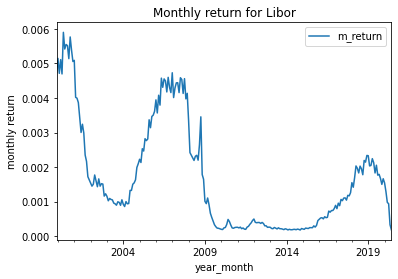

In [ ]:
libor_rate_m.plot(x = 'year_month',y = 'm_return')
plt.ylabel('monthly return')
plt.title('Monthly return for Libor')

In [ ]:
# libor_rate.isna().sum()
# libor_rate.return does not have na, however,dates are not exactly daily, no weekends and no 1-1 ~ 1-3

### Read Spxt, market index



Dow Jones, S&P 500 and Nasdaq Composite

I only use spxt sheet, Vix sheet is ignored...



In [ ]:
spxt = pd.read_excel('/content/drive/My Drive/SWIB Quant Intern/data folder/SPXTVIX.xlsx',sheet_name='SPXT')  
spxt['year_month'] = pd.to_datetime(spxt['Dates']).dt.to_period('M')
spxt['Dates'] = pd.to_datetime(spxt['Dates']).dt.to_period('D')

In [ ]:
# spxt does not have Nan, hence does not need fillna('ffill')
# spxt.isna().sum()
spxt

,Dates,SPXT,year_month
0,2000-01-03,2002.11,2000-01
1,2000-01-04,1925.41,2000-01
2,2000-01-05,1929.28,2000-01
3,2000-01-06,1931.51,2000-01
4,2000-01-07,1983.83,2000-01
...,...,...,...
5330,2020-06-08,6615.40,2020-06
5331,2020-06-09,6564.27,2020-06
5332,2020-06-10,6529.42,2020-06
5333,2020-06-11,6145.30,2020-06


Originally I thought some dates are missing, However, it is weekends. Sunday Saturday don't have data. 

Calculate month return and daily return. 

we need daily return to calculate beta, and monthly return for calculate excess return.

From Roger:"For monthly data,  if we need to predict T+1, we can use data up to T
In that case, Mom1M is T excess return
Momentum is T-11 to T -1
Momentum is T-36 to T
We can start with only these 3 momentum signal"

At this point, my understanding is that, we need to calculate (T-11 to T-1) and (T-36 to T ) cumulative excess return.  What I did before was rolling T-11 to T-1 monthly excess return.

Updates: From paper ML and its previous paper, suppose we were at month t-1 to predict month t. And Y is absolute return - rf.
1. maxrev: Maximum daily return from returns during calendar month t-1.
2. mom12m: 11-month cumulative returns ending one month before month end. t-12:t-2.
3. mom1m: 1-month cumulative return. t-1
4. mom36m: Cumulative returns from months t -36 to t-13.
5. mom6m: 5-month cumulative returns ending one month before month end,t-6:t-2
7. retvol: Standard deviation of daily returns from month t-1.

Note that previously I supposed we were at month t to predict t+1

In [ ]:
# 1. spxt daily market data, which has date, daily return. 
# 2. spxt_m monthly market data, which has year_month, m_return,mom12, mom36  

# df.loc[mask, 'name']  returns a series instead of scalar, df.loc[mask, 'name'].iloc[0] returns a scalar however, if series is empty will get error
def empty_series(ele, loc = 0): return np.nan if ele.empty else ele.iloc[loc]
# 
spxt['d_return'] = spxt['SPXT'].pct_change()
# note that when left_join libor_rate to spxt, there will be nans, since some dates in spxt are missing in libor
spxt['libor_d_return'] = [empty_series(libor_rate.loc[libor_rate['Dates'] == t,'d_return']) for t in spxt['Dates']]
# impute nas using ffill.
spxt['libor_d_return'] = spxt['libor_d_return'].fillna(method='ffill')
spxt['market_risk_premium'] = spxt['d_return']- spxt['libor_d_return']

When left_join libor_d to Spxt, there are 168 nas for libor_d_return, the reason is that libor_d does not have that dates' data.

In [ ]:
# na filled, 
spxt.isna().sum()

Dates                  0
SPXT                   0
year_month             0
d_return               1
libor_d_return         1
market_risk_premium    1
dtype: int64

Text(0.5, 1.0, 'Daily return for Market and libor')

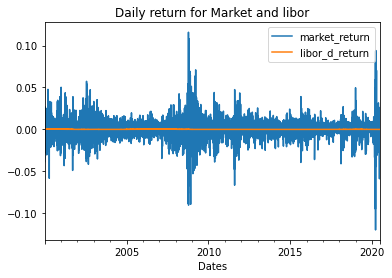

In [ ]:
spxt.plot(x= 'Dates', y = ['d_return','libor_d_return'])
plt.legend(['market_return', "libor_d_return"])
plt.title('Daily return for Market and libor')

In [ ]:
# initialize df spxt_m
spxt_m = pd.DataFrame({'year_month': spxt.year_month.unique()})
# monthly return for market
spxt_m['m_return'] = [ ( spxt.loc[spxt['year_month'] == T, 'SPXT'].iloc[-1] -  spxt.loc[spxt['year_month'] == T, 'SPXT'].iloc[0] )/
                      spxt.loc[spxt['year_month'] == T, 'SPXT'].iloc[0] for T in spxt_m['year_month']] 
spxt_m['mom12m'] = [ ( empty_series( spxt.loc[spxt['year_month'] == T -1,'SPXT'], -1) - empty_series(spxt.loc[spxt['year_month'] == T -11,'SPXT']) ) / 
                                empty_series(spxt.loc[spxt['year_month'] == T -11,'SPXT'])
                                for T in spxt_m['year_month']]
# cumulative T-36 to T-13 cumulative return
spxt_m['mom36m'] = [ ( empty_series( spxt.loc[spxt['year_month'] == T -12,'SPXT'], -1) - empty_series(spxt.loc[spxt['year_month'] == T -35,'SPXT']) ) / 
                                empty_series(spxt.loc[spxt['year_month'] == T -35,'SPXT'])
                                for T in spxt_m['year_month']]

spxt_m['mom6m'] = [ ( empty_series( spxt.loc[spxt['year_month'] == T -1,'SPXT'], -1) - empty_series(spxt.loc[spxt['year_month'] == T -5,'SPXT']) ) / 
                               empty_series(spxt.loc[spxt['year_month'] == T -5,'SPXT'])
                               for T in spxt_m['year_month']]
spxt_m['libor_m_return'] = [empty_series(libor_rate_m.loc[libor_rate_m['year_month'] == T,'m_return']) for T in spxt_m['year_month']]


In [ ]:
spxt_m.isna().sum()

year_month         0
m_return           0
mom12m            11
mom36m            35
mom6m              5
libor_m_return     0
dtype: int64

Text(0.5, 1.0, 'Market Monthly return')

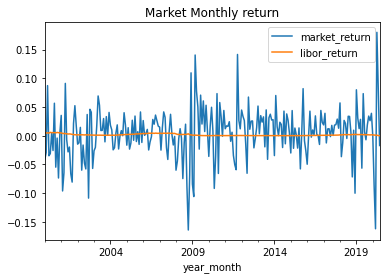

In [ ]:
spxt_m.plot(x= 'year_month', y = ['m_return','libor_m_return'])
plt.legend(['market_return', "libor_return"])
plt.title('Market Monthly return')

Text(0.5, 1.0, 'Market Monthly Momentum')

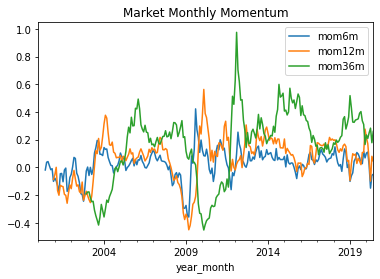

In [ ]:
spxt_m.plot(x= 'year_month', y = ['mom6m','mom12m','mom36m'])
# plt.legend([''])
plt.title('Market Monthly Momentum')

### Read individual stock index

In [6]:
def load_basic_data(fileName):

        tempDF = pd.read_parquet(fileName)
        
        tempDF['date'] = pd.to_datetime(tempDF['date'])

        tempDF['year_month'] = pd.to_datetime(tempDF['date']).dt.to_period('M'); 

        tempDF['date'] = pd.to_datetime(tempDF['date']).dt.to_period('D'); 
 
        return tempDF

tempDF = load_basic_data("/content/drive/My Drive/SWIB Quant Intern/data folder/SP500.pq")

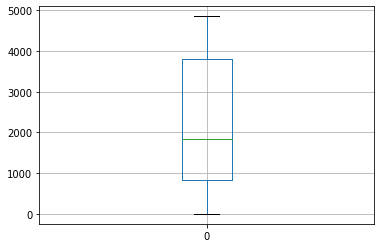

In [ ]:
# all stock_i, groupby sedol,  number of dates in a month, and total month
num_of_days = tempDF.groupby(['sedol','year_month']).size().to_frame().reset_index().rename(columns={0:'num_of_dates'})
num_of_month = num_of_days.groupby('sedol').year_month.size().to_frame().reset_index().rename(columns={'year_month':'total_month'}).sort_values(by = 'total_month')
tempDF.groupby('sedol').size().to_frame().reset_index().boxplot(0)

Text(0.5, 0, 'num of total month')

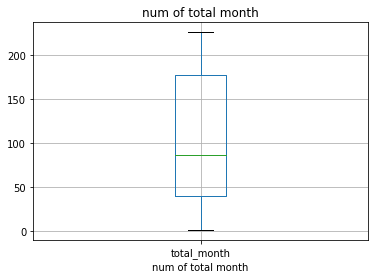

In [ ]:
num_of_month.boxplot('total_month')
plt.title('num of total month')

# Build Signals

For each stock_i where $i \in \{ 1,...1069\}$. we convert daily data to monthly data in order to remove noise. We group daily data by year_month. Suppose month T is the current month.

stock_i_Month_T return = (Price_T.iloc[-1] - Price_T.iloc[0]) / Price_T.iloc[0]. (This is a little different from libor monthly return where we used Price_T.iloc[-1] - Price_T-1.iloc[-1]/... since we don't have price data for libor.)

stock_i_month_T_excess_return = stock_i_month_T_return - market_month_T_return.

stock_i_excess_mom = stock_i_mom - market_mom 

Since our prediction is excess return, momentum should be in the same space as Y.

  Y: next month excess return(T+1). 

  Mom1m:  this month excess return (T)

  Mom12m: previous T-11:T-1 cumulative excess return.

  mom36: T-35:T-12 cumulative excess return.  

  maxret1 : max monthly excess return in the last 12 month

  maxret2 : max daily excess return in the last 1 month

  turnover: dollar volume / market cap

  beta: roll 252 days calculation against index. return_i - rf = beta * (return_m - rf). Beta time-dependent: Beta_i_T I used the lastest available 252 days before last day of monthT. Set threshold ==100 if latest available dates are smaller than 100, beta is nan.

  beta^2

  retvol: stdev(daily excess return)*sqrt(252). ?  Spaces have to be consistent with y,use daily excess return instead of daily return. 

  idiovol: stdev(daily regression residual)*sqrt(252)

Note: We cross sectionally rank all features, At first I didn't rank Y, however, the R^2 and SHAP are very bad, so I ranked Y to make it better.  

In [ ]:
# remove stocks with total dates smaller than 252.  
# total_dates = tempDF.groupby('sedol').size().to_frame().reset_index().rename(columns={0:'total_dates'})
# stock_id = list(total_dates.loc[total_dates['total_dates'] >=252 ,'sedol'])
# print(len(stock_id))

In [ ]:
# for all stock_id
# stock id, total of 1069 stocks,  remove unwanted sedols afterwards. 
# stock_i is daily data, spxt is market daily data.  spxt_m is market monthly data .stock_i_month is what should be returned.
stock_id = list(tempDF.sedol.unique()) 

stock_month = pd.DataFrame({'year_month':[],'sedol':[],'sector':[],'m_volume':[],
                            'm_return':[], 'spxt_m_return':[],'excess_return':[],
                            'next_month_excess_return':[], # shift 
                            'mom6m':[],'spxt_mom6m':[], 'excess_mom6m':[],
                            'mom12m':[],'spxt_mom12m':[], 'excess_mom12m':[],
                            'mom36m':[],'spxt_mom36m':[], 'excess_mom36m':[],
                            'maxret1':[],'maxret2':[],'dollarVolume':[],'mktcap':[],'turnover':[],
                            'beta':[],'beta_sq':[],'retvol':[],'idiovol':[] })


# for stock i, 0-300, 300-600, 600-1069
for i in np.arange(0,300):
    print(i)
    # stock_i is daily, which is used for constructing stock_month
    stock_i = tempDF[tempDF['sedol'] == stock_id[i]]; stock_i = stock_i.sort_values(by = ['date']) # make sure the date is correct
    stock_i = stock_i.fillna(method = 'ffill')
    stock_i_sector = stock_i['sector'].unique() # sometimes na + sector
    time_i = list(stock_i['year_month'].unique())

    # intitial new df using spxt_m, save stock_i monthly data, use spxt mom to obtain excess momentum.
    stock_i_month = spxt_m.loc[spxt_m['year_month'].isin(time_i),['year_month','m_return','mom6m','mom12m','mom36m']].sort_values(by = 'year_month').rename(
        columns={'m_return':'spxt_m_return','mom6m':'spxt_mom6m','mom12m':'spxt_mom12m','mom36m':'spxt_mom36m'})

    # stock id and sector
    stock_i_month.insert(1, 'sedol', stock_id[i]); stock_i_month.insert(2,'sector',  stock_i_sector[-1])

    # Since it is VOLUME_AVG_30D, I use the .iloc[-1] of that month to represent that month's volume.
    stock_i_month['m_volume'] = [  stock_i[stock_i['year_month'] == T]['VOLUME_AVG_30D'].iloc[-1]   for T in time_i ]

    # stock_i monthly return, (price.T.iloc[-1] - price.T.iloc[0] ) / price.T.iloc[0]
    stock_i_month['m_return'] = [ (stock_i[stock_i['year_month'] == T].LAST_PRICE.iloc[-1] - stock_i[stock_i['year_month'] == T].LAST_PRICE.iloc[0])/ 
                                stock_i[stock_i['year_month'] == T].LAST_PRICE.iloc[0]  for T in time_i ]

    # stock_ i excess return
    stock_i_month['excess_return'] = stock_i_month['m_return'] - stock_i_month['spxt_m_return']

    # next month excess return (T+1), Y, shift
    stock_i_month['next_month_excess_return'] = stock_i_month['excess_return'].shift(-1)  # [ empty_series( stock_i_month[stock_i_month['year_month'] == T+1 ].excess_return ) for T in time_i]   #.  np.concatenate( ( stock_i_month['excess_return'].to_list()[1:] , [np.nan]) )

    # mom6m: 
    stock_i_month['mom6m'] = [ (empty_series(stock_i[stock_i['year_month'] == T-1].LAST_PRICE, -1) - empty_series(stock_i[stock_i['year_month'] == T-5].LAST_PRICE,0) )/ 
                                empty_series(stock_i[stock_i['year_month'] == T-5].LAST_PRICE,0)  for T in time_i ]

    stock_i_month['excess_mom6m'] = stock_i_month['mom6m'] - stock_i_month['spxt_mom6m']

    # Momentum, previous T-11 :  T-1 month excess cumulative return. 
    stock_i_month['mom12m'] = [ (empty_series(stock_i[stock_i['year_month'] == T -1].LAST_PRICE, -1) - empty_series(stock_i[stock_i['year_month'] == T-11].LAST_PRICE,0) )/ 
                                empty_series(stock_i[stock_i['year_month'] == T-11].LAST_PRICE,0)  for T in time_i ]

    stock_i_month['excess_mom12m'] = stock_i_month['mom12m'] - stock_i_month['spxt_mom12m']
    # mom36: last 36 month excess cumulative return.
    stock_i_month['mom36m'] = [ (empty_series(stock_i[stock_i['year_month'] == T-12].LAST_PRICE, -1) - empty_series(stock_i[stock_i['year_month'] == T-35].LAST_PRICE,0) )/ 
                                empty_series(stock_i[stock_i['year_month'] == T-35].LAST_PRICE,0)  for T in time_i ]

    stock_i_month['excess_mom36m'] = stock_i_month['mom36m'] - stock_i_month['spxt_mom36m']

    # maxret1, max monthly excess return in the last 12 month, from T-12 : T
    def maxret1(series):
        return np.nan if series.size < 12 else series.max()
    stock_i_month['maxret1'] = [ maxret1( stock_i_month[ (stock_i_month['year_month'] >= T -12 ) & (stock_i_month['year_month'] <= T  )].excess_return)  for T in time_i]
    # maxret2, max daily excess return in the last 1 month
    stock_i_month['maxret2'] = [ stock_i[stock_i['year_month'] == T].d_return.max()  for T in time_i]

    # turnover: dollarvolume/ marketcap
    # Dollarvolume,  dollarVolume_T.iloc[-1].  which equals to price_T.iloc[-1]* volume_T.iloc[-1]
    # marketcap mktcap_T.mean()
    stock_i_month['dollarVolume'] = [stock_i[stock_i['year_month'] == T].dollarVolume.iloc[-1]  for T in time_i]
    stock_i_month['mktcap'] = [ stock_i[stock_i['year_month'] == T].mktcap.mean()    for T in time_i]
    stock_i_month['turnover'] = stock_i_month['dollarVolume']/stock_i_month['mktcap']
    
    # beta, roll 252 days , r_i -rf ~ beta r_m -rf.
    beta = list()
    retvol = list()
    idiovol = list()
    for T in time_i:
      last_date = stock_i[stock_i['year_month'] == T].date.iloc[-1]
      start_date = last_date - 252
      # daily data for stock_i, for the most recent 252 days, however, maybe not available up to 252 days. set threshold ==100
      stock_i_T = stock_i.loc[ (stock_i['date'] >= start_date) &  (stock_i['date'] <= last_date), ['date','sedol','d_return']]
      # if available data smaller than 100, return nan.
      if stock_i_T.date.size <=100: 
        beta.append(np.nan)
        retvol.append(np.nan)
        idiovol.append(np.nan)
        continue
      # def empty_series, if at date_t, spxt[ spxt['Dates'] == str(t) ].d_return maybe empty series, then iloc will get error
      stock_i_T['spxt_d_return'] = [ empty_series( spxt[ spxt['Dates'] == t ].d_return  )  for t in stock_i_T['date']  ] 
      stock_i_T['spxt_d_return'] = stock_i_T['spxt_d_return'].fillna(method = 'ffill')
      # daily excess return
      stock_i_T['excess_return'] = stock_i_T['d_return'] - stock_i_T['spxt_d_return']
      # libor return
      stock_i_T['libor_return'] = [ empty_series( libor_rate[ libor_rate['Dates'] == t ].d_return  )  for t in stock_i_T['date']  ] 
      stock_i_T['libor_return'] = stock_i_T['libor_return'].fillna(method = 'ffill')
      # risk premium and market premium
      stock_i_T['risk_premium'] = stock_i_T['d_return'] - stock_i_T['libor_return']
      stock_i_T['market_premium'] = stock_i_T['spxt_d_return'] - stock_i_T['libor_return']
      # retvol: std(excess d_return), for the most recent 252 days, however, maybe not available up to 252 days.
      retvol.append(stock_i_T['excess_return'].std())
      # run linear regression r_i ~ r_m
      reg = LinearRegression().fit(stock_i_T.dropna()[['risk_premium']],stock_i_T.dropna()[['market_premium']] )
      beta.append(reg.coef_[0][0])
      # residual
      predicted = reg.predict(stock_i_T.dropna()[['market_premium']]).reshape((-1,))
      residual = stock_i_T.dropna().risk_premium.to_numpy() - predicted
      idiovol.append(np.std(residual))
      del reg
      # garbage collect
      del stock_i_T

    stock_i_month['beta'] = beta
    stock_i_month['beta_sq'] = [ele**2 for ele in beta]
    stock_i_month['retvol'] = retvol
    stock_i_month['idiovol'] = idiovol

    # merge stock_i to previous DF
    stock_month = pd.concat([stock_month,stock_i_month])
    # garbage collect
    del stock_i_month, stock_i


# stock_month.to_pickle('/content/drive/My Drive/SWIB Quant Intern/stock_month_0_300.pkl')
# Save stock_month as .pkl
# It runs slowly So I partitioned the job and merge them
# stock_month.to_pickle('/content/drive/My Drive/SWIB Quant Intern/stock_month.pkl')



In [7]:
# read in and combine
#df1 = pd.read_pickle('/content/drive/My Drive/SWIB Quant Intern/stock_month_0_300.pkl')
#df2 = pd.read_pickle('/content/drive/My Drive/SWIB Quant Intern/stock_month_300_600.pkl')
#df3 = pd.read_pickle('/content/drive/My Drive/SWIB Quant Intern/stock_month_600_1069.pkl')
#stock_month = pd.concat([df1,df2,df3])
#stock_month.to_pickle('/content/drive/My Drive/SWIB Quant Intern/stock_month_6_25.pkl')

# Stock_month final data already saved, so directly load
stock_month = pd.read_pickle('/content/drive/My Drive/SWIB Quant Intern/stock_month_6_25.pkl')

# map T: 2001-06: 0,    2020-06 :226
# Map 2001-09 - 2020-06 to T 0 - 225
T = tempDF['year_month'].unique()
T = dict(zip (T,np.arange(len(T))))
stock_month['Month_T'] = stock_month['year_month'].map(T)

### Rank features
Next step, Cross sectionally rank all features...

In [116]:
# save unranked columns, first time didn't rank Y, R-sq -0.04 very bad, let's rank Y to see.
# stock_month_r = stock_month.loc[:,['year_month','sedol','Month_T','sector','next_month_excess_return']]
stock_month_r = stock_month.loc[:,['year_month','sedol','Month_T','sector']]

# combine the ranked columns with previous df
stock_month_r = pd.concat( [stock_month_r, stock_month.loc[:,['excess_return', 'excess_mom6m', 'excess_mom12m','excess_mom36m','maxret1','maxret2',
                   'turnover','mktcap','beta','beta_sq','retvol','idiovol','Month_T','next_month_excess_return'] ].groupby('Month_T').rank(pct = True)],
                   axis=1 )
stock_month_r

,year_month,sedol,Month_T,sector,excess_return,excess_mom6m,excess_mom12m,excess_mom36m,maxret1,maxret2,turnover,mktcap,beta,beta_sq,retvol,idiovol,next_month_excess_return
20,2001-09,2001692,0,Industrials,0.822000,NaN,NaN,NaN,NaN,0.910000,0.860000,0.196000,NaN,NaN,NaN,NaN,0.124000
21,2001-10,2001692,1,Industrials,0.123260,NaN,NaN,NaN,NaN,0.697813,0.715706,0.194831,NaN,NaN,NaN,NaN,0.802000
22,2001-11,2001692,2,Industrials,0.802789,NaN,NaN,NaN,NaN,0.818725,0.840637,0.169323,NaN,NaN,NaN,NaN,0.681363
23,2001-12,2001692,3,Industrials,0.684524,NaN,NaN,NaN,NaN,0.750000,0.759921,0.182540,NaN,NaN,NaN,NaN,0.958000
24,2002-01,2001692,4,Industrials,0.958250,NaN,NaN,NaN,NaN,0.882704,0.773360,0.204771,NaN,NaN,NaN,NaN,0.853707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,2020-06,B01SD70,225,Consumer Discretionary,0.073267,NaN,NaN,NaN,NaN,0.104950,0.942574,0.360396,NaN,NaN,NaN,NaN,NaN
244,2020-05,B0796X4,224,Health Care,0.029528,NaN,NaN,NaN,NaN,0.305118,0.937008,0.708661,NaN,NaN,NaN,NaN,0.031683
245,2020-06,B0796X4,225,Health Care,0.031683,NaN,NaN,NaN,NaN,0.693069,0.936634,0.667327,NaN,NaN,NaN,NaN,NaN
244,2020-05,2950482,224,Health Care,0.183071,NaN,NaN,NaN,NaN,0.350394,0.883858,0.397638,NaN,NaN,NaN,NaN,0.055446


Cross sectionally rank all features, and checked that each month has 491~ 512 stocks. 

Text(0, 0.5, 'num of stocks')

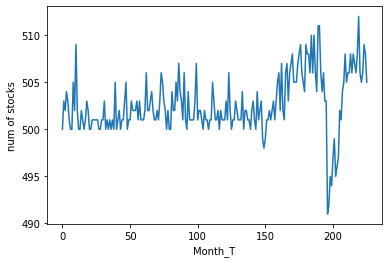

In [97]:
# How many stocks in each month, 491 ~ 512
stock_month.groupby('Month_T').sedol.size().plot()
plt.ylabel('num of stocks')

# Build Prediction Model

let $T \in \{0,1,2,....,225 \}$ denote the month index, 
let $ i \in \{1,2,....,1069 \}$ denote the stock index. 
The response variable is Next_month_excess_return, denoted as $r_{i,T+1}$, of stock i and month T+1. 
The predictive characteristics are denoted as P-dimensional vector $z_{i,T}$, 
T is 0,2....225 following "citi-bank" paper, which measures the overal time trend for the macromarket.

1.  we consider regression problem, which means that the objective function is minimization of MSE. 

   $r_{i,T+1} = g(z_{i,T}) + \epsilon_{i,T+1}$
   
       

2.  we consider classification problem, for example a binary classification of whether d_return is positive or not. 
   
   $P(r_{i,T+1} > 0 | z_{i,T}) = g(z_{i,T})$

Following the paper(ML), The g function depends neither on i or T. By maintaining the same form over time and across different stocks, the model leverages information from the entire panel and every individual asset. Also g(.) depends on z only through $z_{i,T}$.


We split sample into 2 disjoint time periods, 2001-2013 as training, 2014-2020 as testing.

Regarding performance evaluation for regression, we use R square $R^2_{oos} = 1 - \frac{\sum_{(i,T)\in test}(r_{i,T+1}-\hat{r}_{i,T+1})^2}{\sum_{(i,T)\in test} r^2_{i,T+1}}$, 
and F1,accuracy for classification.






In [118]:
# How to handle missing data? 
# I remove all rows contains NA

stock_month_dropna = stock_month_r.dropna()
stock_month_dropna

,year_month,sedol,Month_T,sector,excess_return,excess_mom6m,excess_mom12m,excess_mom36m,maxret1,maxret2,turnover,mktcap,beta,beta_sq,retvol,idiovol,next_month_excess_return
55,2004-08,2002305,35,Health Care,0.914172,0.351626,0.307377,0.223476,0.276639,0.206587,0.049900,0.940120,0.481781,0.481781,0.431174,0.382591,0.388778
56,2004-09,2002305,36,Health Care,0.390000,0.595142,0.301848,0.216704,0.295688,0.137000,0.058000,0.944000,0.620202,0.620202,0.355556,0.323232,0.564000
57,2004-10,2002305,37,Health Care,0.562874,0.462626,0.383197,0.213483,0.288934,0.619760,0.071856,0.942116,0.652525,0.652525,0.317172,0.292929,0.100200
58,2004-11,2002305,38,Health Care,0.100000,0.526316,0.327160,0.238839,0.302469,0.621000,0.090000,0.944000,0.659274,0.659274,0.318548,0.302419,0.897796
59,2004-12,2002305,39,Health Care,0.899010,0.410101,0.222680,0.237251,0.303093,0.823762,0.087129,0.942574,0.705645,0.705645,0.260081,0.243952,0.364000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2020-05,BD0Q558,224,Industrials,0.415354,0.651911,0.821803,0.689977,0.178197,0.185039,0.074803,0.643701,0.575453,0.575453,0.404427,0.444668,0.421782
244,2020-05,2045623,224,Information Technology,0.645669,0.861167,0.964361,0.871795,0.618449,0.177165,0.279528,0.561024,0.764588,0.764588,0.148893,0.265594,0.194059
244,2020-05,2556868,224,Financials,0.937008,0.148893,0.167715,0.356643,0.572327,0.568898,0.728346,0.143701,0.539235,0.539235,0.444668,0.492958,0.861386
244,2020-05,2679204,224,Health Care,0.948819,0.374245,0.236897,0.983683,0.958071,0.911417,0.858268,0.452756,0.231388,0.231388,0.776660,0.806841,0.819802


In [119]:
# number of stocks left in training
len(stock_month_dropna.sedol.unique())

826

In [141]:
# split data, remember after remove NAs, T starts from 35 to 225. 
# training 36: 180,   testing 180:225

features = ['Month_T', 'excess_return', 'excess_mom6m', 'excess_mom12m', 'excess_mom36m','maxret1', 'maxret2', 
        'turnover', 'mktcap', 'beta', 'beta_sq', 'retvol', 'idiovol']


X_train = stock_month_dropna.loc[ stock_month_dropna.Month_T.isin(np.arange(0,180)) , features] ## total 79691,   61197 in training
Y_train = stock_month_dropna.loc[ stock_month_dropna.Month_T.isin(np.arange(0,180)) , 'next_month_excess_return']

X_test = stock_month_dropna.loc[ stock_month_dropna.Month_T.isin(np.arange(180,226)) , features] # 
Y_test = stock_month_dropna.loc[ stock_month_dropna.Month_T.isin(np.arange(180,226)) , 'next_month_excess_return'] # 18494 in test


In [142]:
# build model, random forest
regr = RandomForestRegressor(max_depth=3,random_state=0)
regr.fit(X_train, Y_train)
print(regr.score(X_test,Y_test)) # default R2 
# r2_score(Y_test.values, regr.predict(X_test))

-0.0006124768198150221


In [147]:
# try xgboots
regr2 = xgb.train({"learning_rate": 0.01}, xgb.DMatrix(X_train,label = Y_train),10)

r2_score(Y_test.values, regr2.predict(xgb.DMatrix(X_test,label = Y_test)) )

5.193058083663438e-06

# SHAP

1. Turn_over is positively correlated with next_month_excess_return. 
2. Mom1m is negatively correlated.
3. excess_mom6m is positively. ...


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


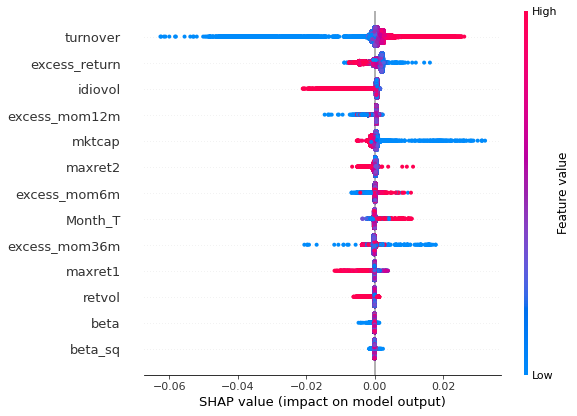

In [148]:
# Shap for random forest
explainer = shap.TreeExplainer(regr)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


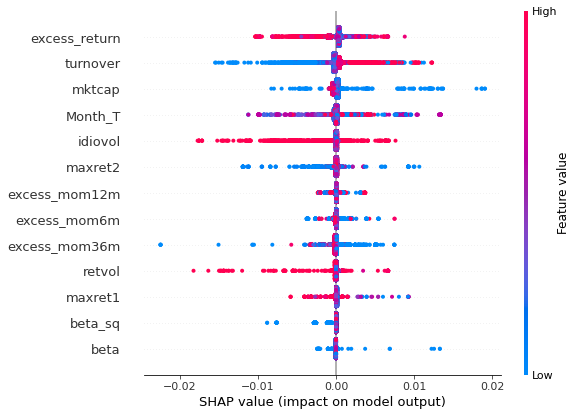

In [149]:
# Shap for xgboost
explainer2 = shap.TreeExplainer(regr2)
shap_values2 = explainer2.shap_values(X_train.values)

shap.summary_plot(shap_values2, X_train)